In [1]:
%matplotlib inline
import json
import numpy as np
import glob
import matplotlib.pyplot as plt
import brewer2mpl
import math
import pandas as pd
bmap = brewer2mpl.get_map('Set1', 'qualitative', 9)
colors = bmap.mpl_colors

In [2]:
LOGDIR = '../log/results1000/'
PARAMS = [
# 'MountainCarContinuousGoal-v0_sarst_future_rnd_2_inf_linear_True_True_2',
# 'sarst_future_rnd_1_inf_linear_True_True_1000_2'
'sarst_future_comp_1_inf_linear_True_True_1000_2'
# 'hsarst_future_comp_2_inf_linear_True_True_1000_0.3',
# 'hsarst_final_goalC_1_inf_linear_True_True_1000_0.3',
# 'hsarst_final_goalC_0.5_inf_linear_True_True_1000_0.3',
# 'hsarst_future_goalC_1_inf_linear_True_True_1000_0.3',
# 'hsarst_future_comp_1_inf_linear_True_True_1000_0.3',
# 'hsarst_future_goalC_2_inf_linear_True_True_1000_0.3',
# 'hsarst_future_comp_0.5_inf_linear_True_True_1000_2',
# 'hsarst_final_comp_2_inf_linear_True_True_1000_0.3',
# 'hsarst_future_goalC_0.5_inf_linear_True_True_1000_0.3',
# 'hsarst_final_goalC_2_inf_linear_True_True_1000_0.3',
# 'hsarst_final_comp_0.5_inf_linear_True_True_1000_2',
# 'hsarst_final_comp_1_inf_linear_True_True_1000_0.3'
  
]

In [3]:
frames = []
for PARAM in PARAMS:
    param_vals = PARAM.split('_')
    res_steps = glob.glob(LOGDIR + PARAM + '/*/' + 'log_steps/progress.json')
    for num_run, run in enumerate(res_steps):
        try:
            df = pd.read_json(run, lines=True)
        except ValueError:
            print("run "+run+": invalid")
        df['params'] = PARAM
        df['num_run']=num_run
        frames.append(df)
expe_res_steps = pd.concat(frames, ignore_index=True)
expe_res_steps

,Test reward on initial goal,Test reward on random goal,critic_loss,d_q_values,mean_Q_values,mean_action,mean_target_Q_values,mean_target_action,q_values,reference_action_grads,training_step,params,num_run
0,NaN,NaN,126.376144,"[0.017474664375185002, 0.017372911795973, 0.01...",0.409052,0.039783,-0.010568,0.006071,"[0.017474664375185002, 0.017372911795973, 0.01...",0.015967,200,sarst_future_comp_1_inf_linear_True_True_1000_2,0
1,NaN,NaN,65.855164,"[0.017474664375185002, 0.017372911795973, 0.01...",0.931241,0.800075,0.002862,0.027498,"[0.017474664375185002, 0.017372911795973, 0.01...",0.338762,400,sarst_future_comp_1_inf_linear_True_True_1000_2,0
2,NaN,NaN,47.086349,"[0.017474664375185002, 0.017372911795973, 0.01...",0.979501,0.946378,-0.028816,0.078896,"[0.017474664375185002, 0.017372911795973, 0.01...",0.631412,600,sarst_future_comp_1_inf_linear_True_True_1000_2,0
3,NaN,NaN,35.389332,"[0.017474664375185002, 0.017372911795973, 0.01...",0.767725,0.961469,-0.106468,0.141500,"[0.017474664375185002, 0.017372911795973, 0.01...",0.607936,800,sarst_future_comp_1_inf_linear_True_True_1000_2,0
4,-3.600026,-6.625318,21.469902,"[0.017474664375185002, 0.017372911795973, 0.01...",0.293212,0.723213,-0.249199,0.209177,"[0.017474664375185002, 0.017372911795973, 0.01...",0.486260,1000,sarst_future_comp_1_inf_linear_True_True_1000_2,0
5,-3.600026,-6.625318,15.888706,"[0.017474664375185002, 0.017372911795973, 0.01...",-0.034536,0.170124,-0.401006,0.242714,"[0.017474664375185002, 0.017372911795973, 0.01...",0.365531,1200,sarst_future_comp_1_inf_linear_True_True_1000_2,0
6,-3.600026,-6.625318,11.734954,"[0.017474664375185002, 0.017372911795973, 0.01...",-0.267148,0.194864,-0.526697,0.242955,"[0.017474664375185002, 0.017372911795973, 0.01...",0.335381,1400,sarst_future_comp_1_inf_linear_True_True_1000_2,0
7,-3.600026,-6.625318,10.532075,"[0.017474664375185002, 0.017372911795973, 0.01...",-0.287485,0.002828,-0.584317,0.226103,"[0.017474664375185002, 0.017372911795973, 0.01...",0.337144,1600,sarst_future_comp_1_inf_linear_True_True_1000_2,0
8,-3.600026,-6.625318,8.063177,"[0.017474664375185002, 0.017372911795973, 0.01...",-0.243615,-0.154968,-0.458500,0.215112,"[0.017474664375185002, 0.017372911795973, 0.01...",0.357011,1800,sarst_future_comp_1_inf_linear_True_True_1000_2,0
9,-3.743578,26.820345,8.819514,"[0.017474664375185002, 0.017372911795973, 0.01...",-0.093732,-0.063805,-0.349851,0.203254,"[0.017474664375185002, 0.017372911795973, 0.01...",0.359276,2000,sarst_future_comp_1_inf_linear_True_True_1000_2,0


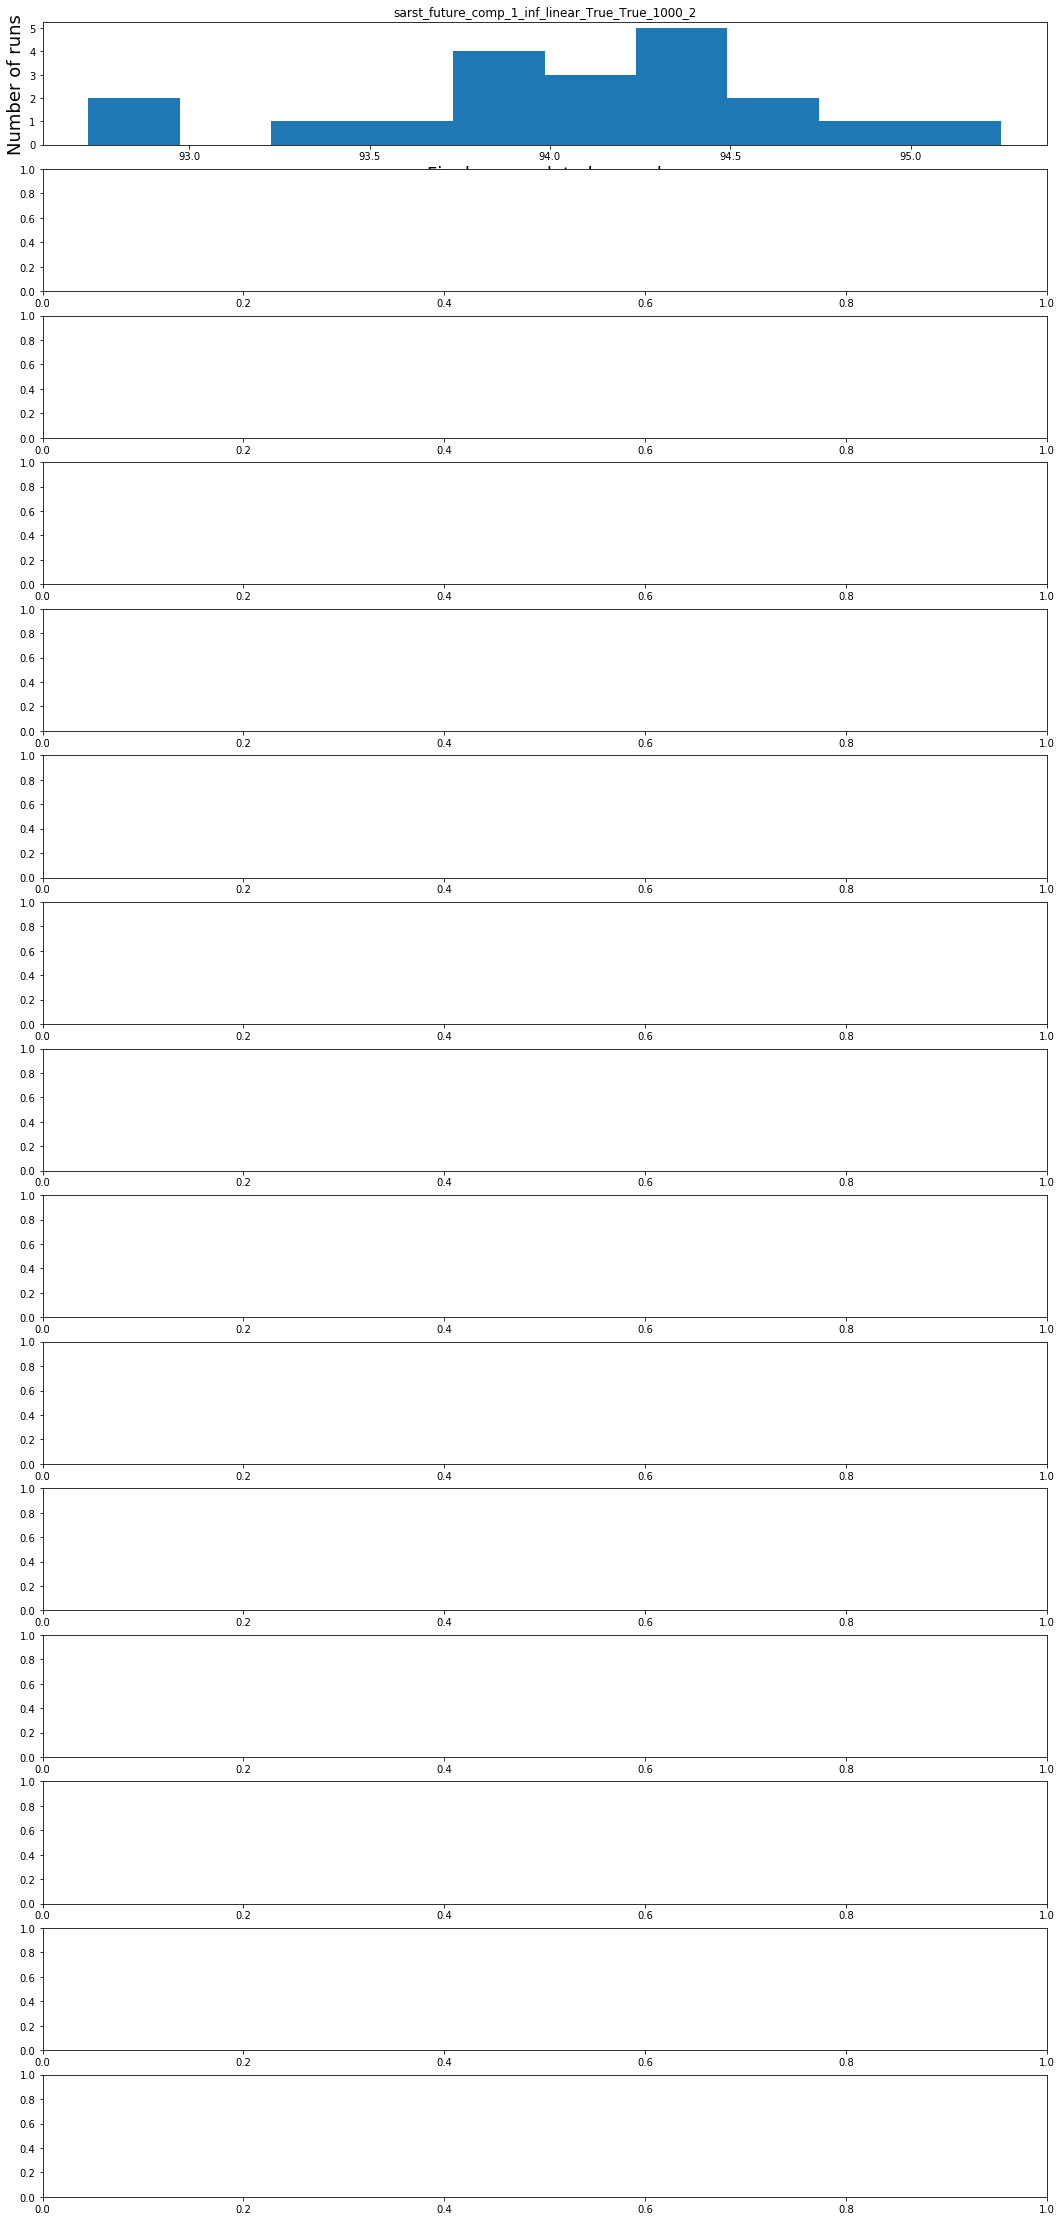

In [4]:
res_final = expe_res_steps[expe_res_steps['training_step']==100000]
fig, axes = plt.subplots(15,1, figsize=(18,40))
for i,(name, g) in enumerate(res_final.groupby('params')['Test reward on initial goal']):
    axes[i].hist(g)
    axes[i].set_title(name)
    axes[i].set_xlabel('Final accumulated reward', fontsize=18)
    axes[i].set_ylabel('Number of runs', fontsize=18)
#     g.plot(kind='hist', title=name, ax=axes[i%7,i//7])
# fig.savefig('/home/pierre/Latex/Slides/pres_17_01_18/images/robust_final.pdf',bbox_inches='tight')

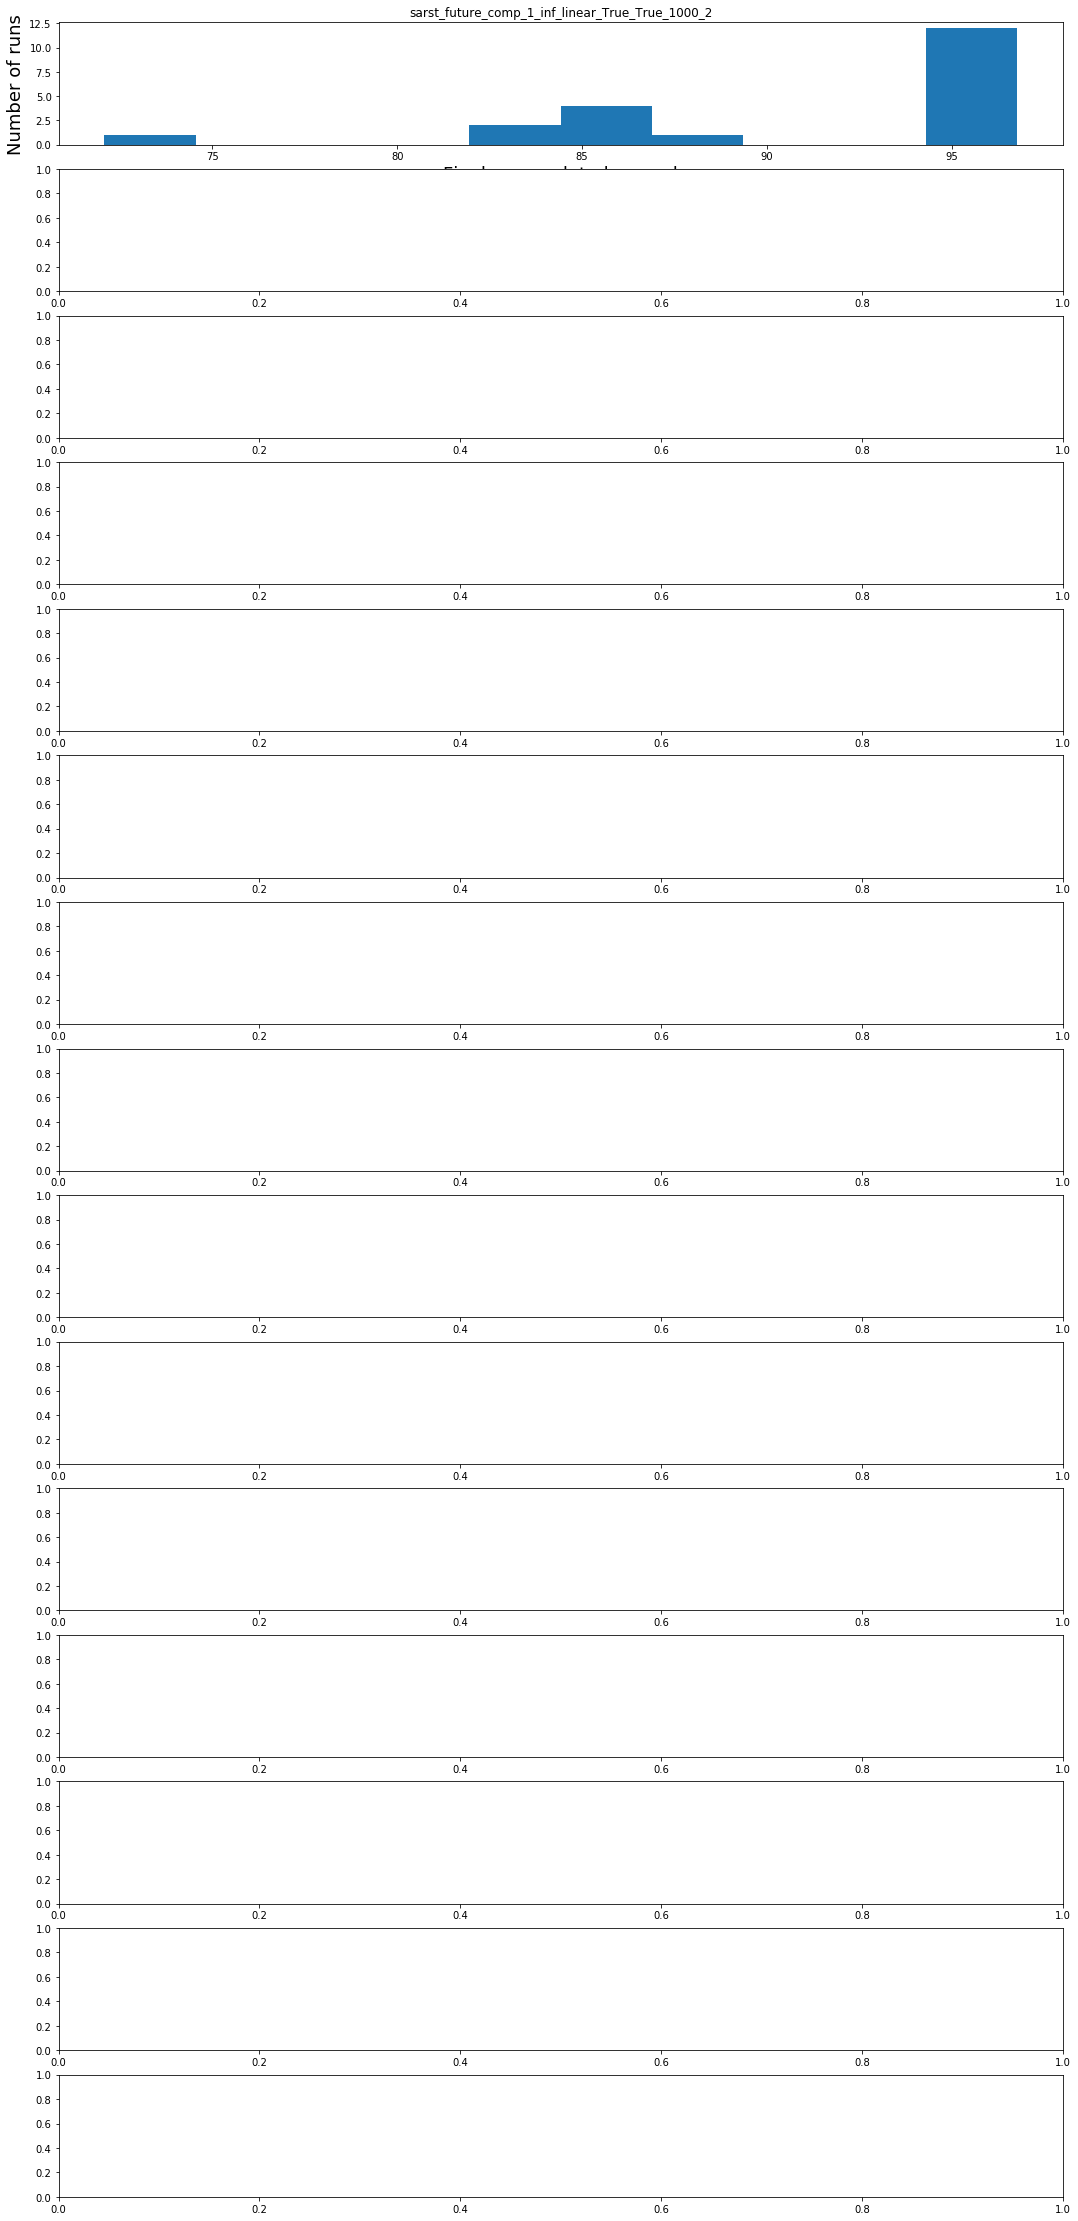

In [5]:
res_final = expe_res_steps[expe_res_steps['training_step']==100000]
fig, axes = plt.subplots(15,1, figsize=(18,40))
for i,(name, g) in enumerate(res_final.groupby('params')['Test reward on random goal']):
    axes[i].hist(g)
    axes[i].set_title(name)
    axes[i].set_xlabel('Final accumulated reward', fontsize=18)
    axes[i].set_ylabel('Number of runs', fontsize=18)

(-5000, 200000)

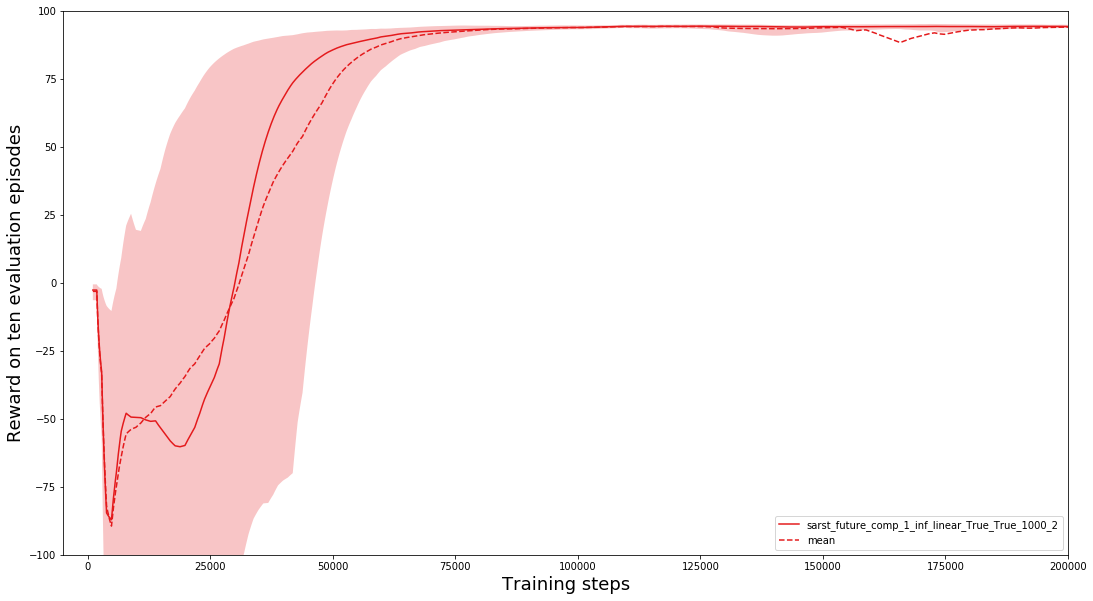

In [6]:
dico = {}
for name, g in expe_res_steps[expe_res_steps['training_step']==100000].groupby('params'):
    dico[name] = list(g[g['Test reward on initial goal']>-100]['num_run'].values)
mask = expe_res_steps.apply(lambda g: g['num_run'] in dico[g['params']], axis=1)
filtered = expe_res_steps[mask]
def quant_inf(x) : return x.quantile(0.1)
def quant_sup(x) : return x.quantile(0.9)
op_dict = {'Test reward on initial goal':[np.mean, np.median, quant_inf,quant_sup]}
columns = ['Test reward on initial goal','training_step','params']
stats_eval_init = filtered[columns].groupby(['training_step','params']).agg(op_dict).reset_index()
stats_eval_init_smooth = stats_eval_init[['params','Test reward on initial goal']].groupby('params').apply(lambda x: x.ewm(30).mean())
stats_eval_init_smooth['trainin_step']=stats_eval_init['training_step']

fig, ax = plt.subplots(figsize=(18,10))
for i, (name, g) in enumerate(stats_eval_init_smooth.groupby(['params'])):
    if name in PARAMS:
        params = name.split('_')
        ax.plot(g['trainin_step'], g['Test reward on initial goal']['median'], label=name, color=colors[i])
        ax.plot(g['trainin_step'], g['Test reward on initial goal']['mean'], color=colors[i], linestyle='dashed')
        ax.fill_between(g['trainin_step'], 
                        g['Test reward on initial goal']['quant_inf'], 
                        g['Test reward on initial goal']['quant_sup'], alpha=0.25, linewidth=0, color=colors[i])
ax.legend(loc=4)
ax.set_xlabel('Training steps', fontsize=18)
ax.set_ylabel('Reward on ten evaluation episodes', fontsize=18)
ax.set_ylim([-100,100])
ax.set_xlim([-5000,200000])
# fig.savefig('/home/pierre/Latex/Slides/pres_17_01_18/images/comparaison_samplers_03.pdf',bbox_inches='tight')

In [164]:
expe_res_steps

,Test reward on initial goal,Test reward on random goal,critic_loss,mean_Q_values,mean_action,mean_target_Q_values,mean_target_action,reference_action_grads,training_step,params,num_run
0,NaN,NaN,0.001294,-0.076198,-0.014244,-0.004141,0.009188,-0.006731,200,MountainCarContinuousGoal-v0_sarst_future_rnd_...,0
1,NaN,NaN,3.459987,-0.033825,-0.803707,-0.010335,-0.012365,-0.065699,400,MountainCarContinuousGoal-v0_sarst_future_rnd_...,0
2,NaN,NaN,14.602386,0.238612,-0.980343,-0.001938,-0.064348,-0.144522,600,MountainCarContinuousGoal-v0_sarst_future_rnd_...,0
3,NaN,NaN,12.135855,0.300231,-0.982623,-0.018134,-0.124810,-0.192523,800,MountainCarContinuousGoal-v0_sarst_future_rnd_...,0
4,-99.823284,-41.896654,12.051509,0.290486,-0.976325,-0.029742,-0.194571,-0.216822,1000,MountainCarContinuousGoal-v0_sarst_future_rnd_...,0
5,-99.823284,-41.896654,15.150122,0.515463,-0.964635,0.150729,-0.252133,-0.242983,1200,MountainCarContinuousGoal-v0_sarst_future_rnd_...,0
6,-99.823284,-41.896654,13.817570,0.617255,-0.993798,0.224797,-0.318568,-0.273264,1400,MountainCarContinuousGoal-v0_sarst_future_rnd_...,0
7,-99.823284,-41.896654,13.668873,0.711478,-0.998329,0.312694,-0.393926,-0.256886,1600,MountainCarContinuousGoal-v0_sarst_future_rnd_...,0
8,-99.823284,-41.896654,14.853999,0.841143,-0.998605,0.353715,-0.464232,-0.240484,1800,MountainCarContinuousGoal-v0_sarst_future_rnd_...,0
9,-99.534817,-58.419999,11.672216,0.869052,-0.998609,0.415927,-0.546875,-0.167996,2000,MountainCarContinuousGoal-v0_sarst_future_rnd_...,0


(-5000, 200000)

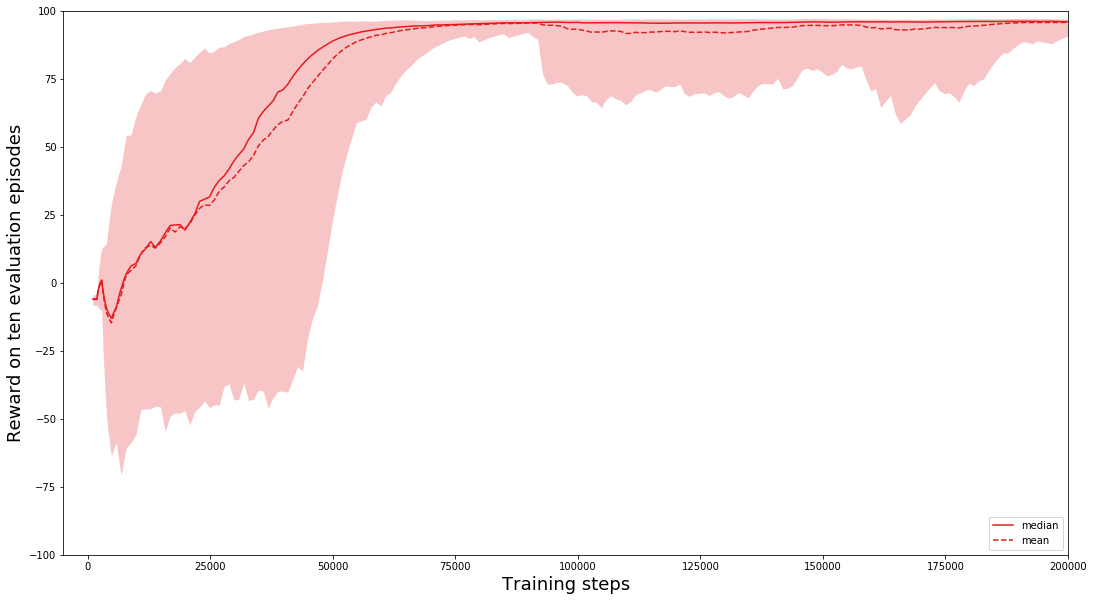

In [29]:
dico = {}
for name, g in expe_res_steps[expe_res_steps['training_step']==100000].groupby('params'):
    dico[name] = list(g[g['Test reward on random goal']>-100]['num_run'].values)
mask = expe_res_steps.apply(lambda g: g['num_run'] in dico[g['params']], axis=1)
filtered = expe_res_steps[mask]
def quant_inf(x) : return x.quantile(0)
def quant_sup(x) : return x.quantile(1)
op_dict = {'Test reward on random goal':[np.mean, np.median, quant_inf,quant_sup]}
columns = ['Test reward on random goal','training_step','params']
stats_eval_init = filtered[columns].groupby(['training_step','params']).agg(op_dict).reset_index()
stats_eval_init_smooth = stats_eval_init[['params','Test reward on random goal']].groupby('params').apply(lambda x: x.ewm(30).mean())
stats_eval_init_smooth['trainin_step']=stats_eval_init['training_step']

fig, ax = plt.subplots(figsize=(18,10))
for i, (name, g) in enumerate(stats_eval_init_smooth.groupby(['params'])):
    if name in PARAMS:
        params = name.split('_')
        ax.plot(g['trainin_step'], g['Test reward on random goal']['median'], color=colors[i])
        ax.plot(g['trainin_step'], g['Test reward on random goal']['mean'], color=colors[i], linestyle='dashed')
        ax.fill_between(g['trainin_step'], 
                        g['Test reward on random goal']['quant_inf'], 
                        g['Test reward on random goal']['quant_sup'], alpha=0.25, linewidth=0, color=colors[i])
ax.legend(loc=4)
ax.set_xlabel('Training steps', fontsize=18)
ax.set_ylabel('Reward on ten evaluation episodes', fontsize=18)
ax.set_ylim([-100,100])
ax.set_xlim([-5000,200000])

In [213]:
mean_q_val = expe_res_steps[['training_step','params','q_values']].groupby(['training_step','params']).apply(pd.Series)
mean_q_val

ValueError: cannot copy sequence with size 3 to array axis with dimension 20

<a list of 34 Text yticklabel objects>


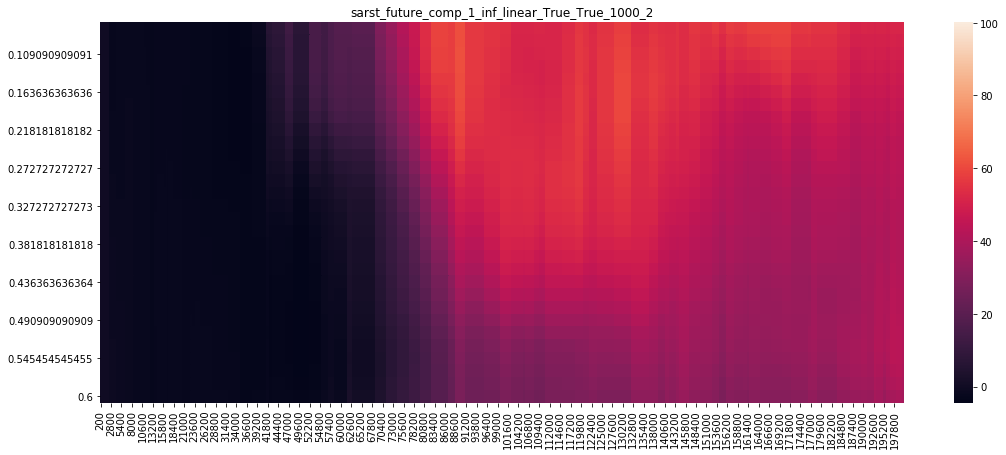

In [51]:
import seaborn as sns
fig, axes = plt.subplots(len(PARAMS), figsize=(18,7))
expe_res_steps_0 = expe_res_steps[(expe_res_steps['num_run']==0)]
# expe_res_steps_0 = expe_res_steps[(expe_res_steps['num_run']==0) & (expe_res_steps['training_step']<=70000)]
for i, (name, g) in enumerate(expe_res_steps_0.groupby('params')):
    q_vals = g['q_values'].apply(pd.Series)
    heatmap = q_vals.T
    heatmap.columns = range(200, 200001,200)
#     heatmap.columns = range(200, 70001,200)
    sns.heatmap(heatmap, ax=axes)
    axes.set_title(name)
    print(axes.get_yticklabels())
    axes.set_ylim([100,70])
    axes.set_yticklabels([list(np.linspace(-1.2, 0.6, 100))[int(label.get_text())] for label in axes.get_yticklabels()])

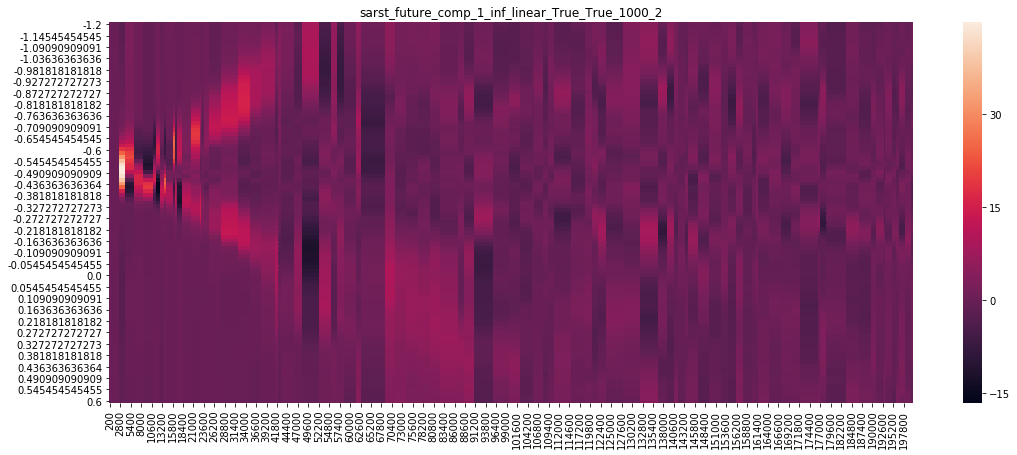

In [42]:
import seaborn as sns
fig, axes = plt.subplots(len(PARAMS), figsize=(18,7))
expe_res_steps_0 = expe_res_steps[(expe_res_steps['num_run']==0)]
# expe_res_steps_0 = expe_res_steps[(expe_res_steps['num_run']==0) & (expe_res_steps['training_step']<=70000)]
for i, (name, g) in enumerate(expe_res_steps_0.groupby('params')):
    q_vals = g['d_q_values'].apply(pd.Series)
    heatmap = q_vals.T
    heatmap.columns = range(200, 200001,200)
#     heatmap.columns = range(200, 70001,200)
    sns.heatmap(heatmap, ax=axes)
    axes.set_title(name)
    axes.set_yticklabels([list(np.linspace(-1.2, 0.6, 100))[int(label.get_text())] for label in axes.get_yticklabels()])
#     axes.set_xlim([0,70000])

In [43]:
frames = []
for PARAM in PARAMS:
    param_vals = PARAM.split('_')
    res_episodes = glob.glob(LOGDIR + PARAM + '/*/' + 'log_episodes/progress.json')
    for num_run, run in enumerate(res_episodes):
        try:
            df = pd.read_json(run, lines=True)
        except ValueError:
            print("run "+run+": invalid")
        df['params'] = PARAM
        df['num_run']=num_run
        frames.append(df)
expe_res_episodes = pd.concat(frames, ignore_index=True)
expe_res_episodes

,Duration,Episode,Episode steps,Final_state,Goal,Goal reached,Start,Train reward,Train step,params,num_run
0,0.215156,1,35,-0.207075,-0.218182,1,-0.481433,97.295769,35,sarst_future_comp_1_inf_linear_True_True_1000_2,0
1,0.514785,2,101,-0.123212,-0.145455,2,-0.456615,92.479165,136,sarst_future_comp_1_inf_linear_True_True_1000_2,0
2,0.544616,3,17,-0.338596,-0.345455,3,-0.597645,98.300000,153,sarst_future_comp_1_inf_linear_True_True_1000_2,0
3,10.886660,4,152,-1.057473,-1.036364,4,-0.443859,87.743435,305,sarst_future_comp_1_inf_linear_True_True_1000_2,0
4,11.879921,5,13,-0.633381,-0.618182,5,-0.492799,98.700000,318,sarst_future_comp_1_inf_linear_True_True_1000_2,0
5,22.346054,6,157,-0.307330,-0.345455,6,-0.443837,86.858679,475,sarst_future_comp_1_inf_linear_True_True_1000_2,0
6,116.192528,7,1000,-0.578187,0.545455,6,-0.502574,-96.510592,1475,sarst_future_comp_1_inf_linear_True_True_1000_2,0
7,212.826460,8,1000,-0.399769,-0.672727,6,-0.480715,-100.000000,2475,sarst_future_comp_1_inf_linear_True_True_1000_2,0
8,215.112139,9,40,0.037898,0.036364,7,-0.583453,96.000000,2515,sarst_future_comp_1_inf_linear_True_True_1000_2,0
9,217.643441,10,40,0.055156,0.054545,8,-0.594253,96.000000,2555,sarst_future_comp_1_inf_linear_True_True_1000_2,0


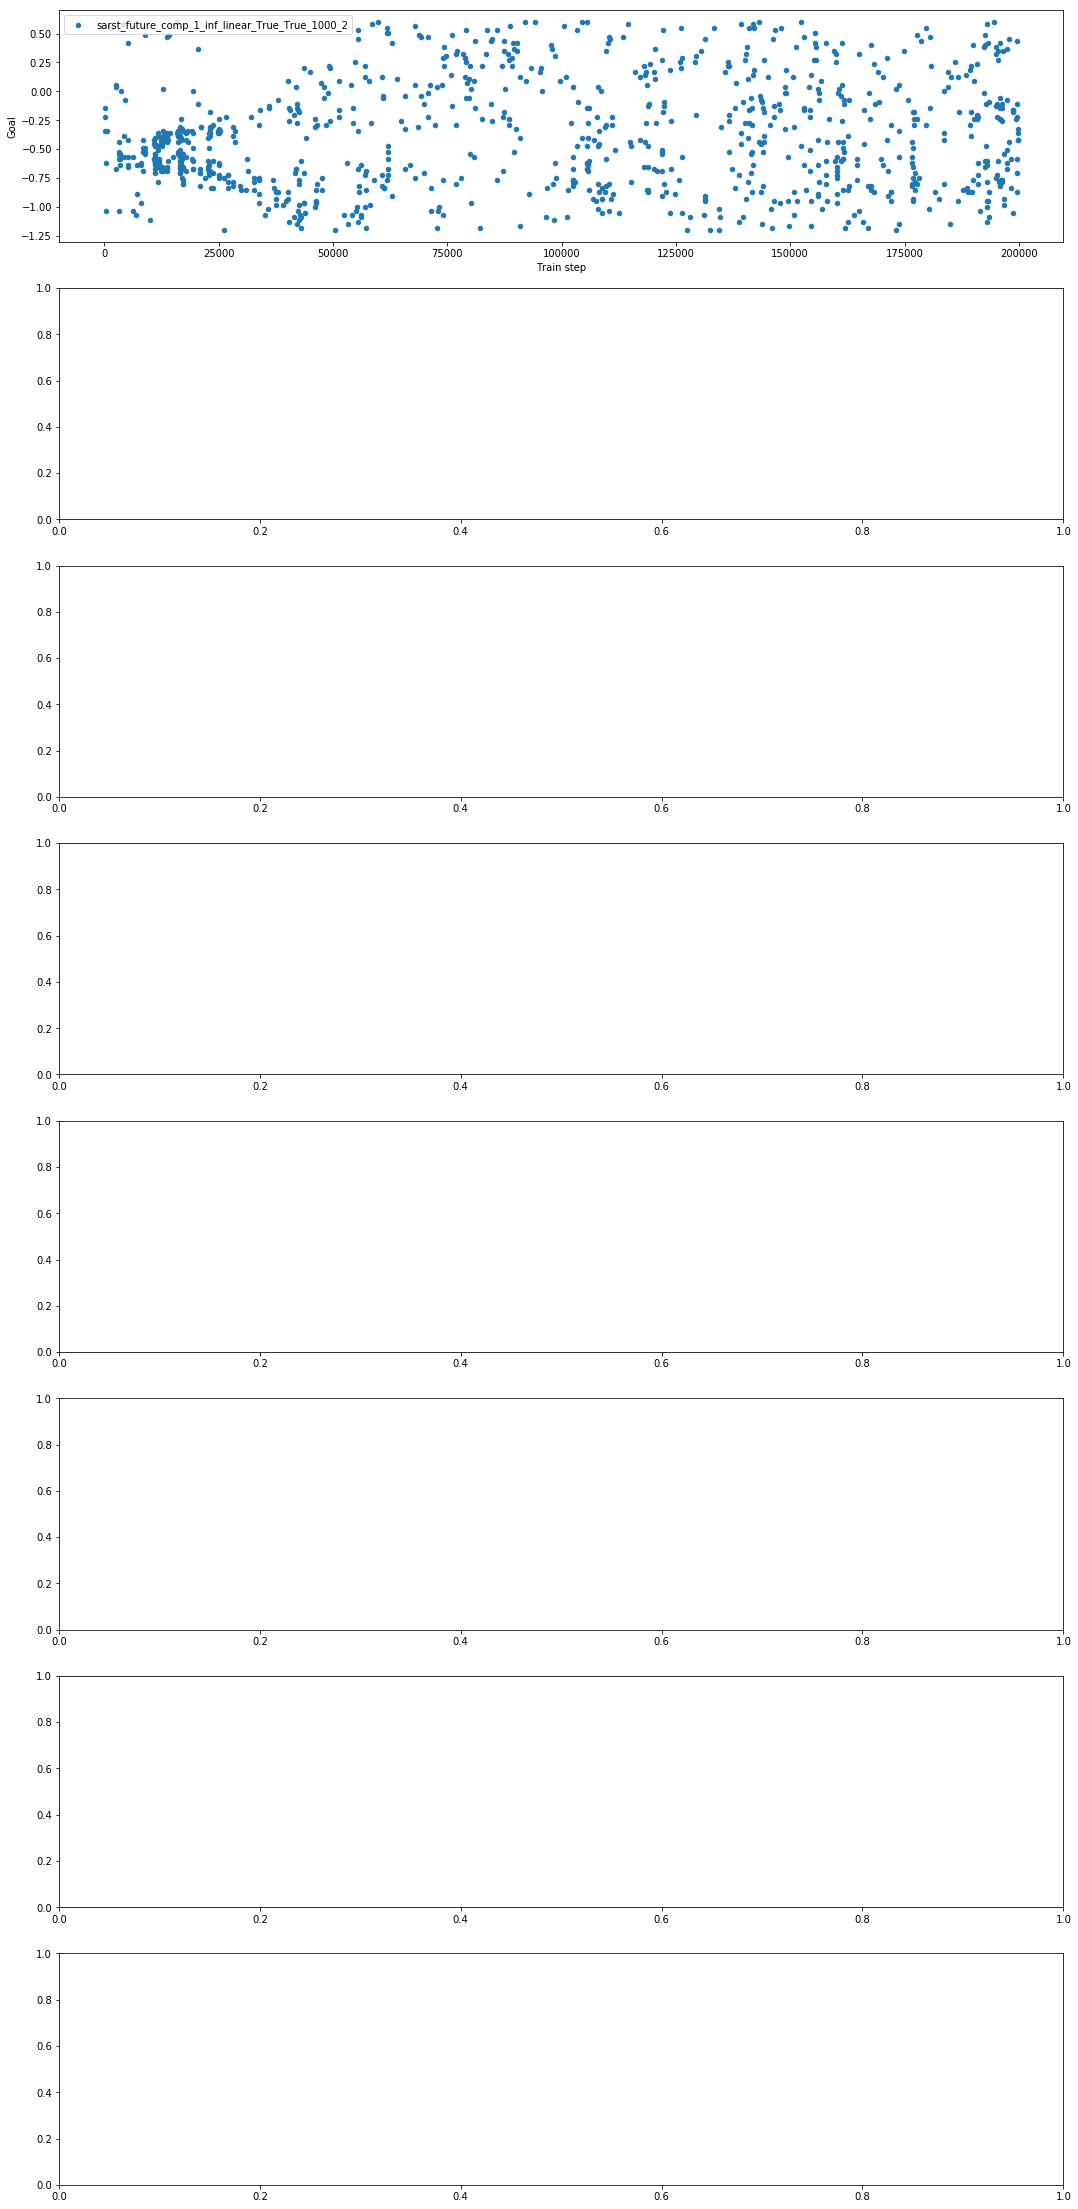

In [44]:
expe_res_ep_plot = expe_res_episodes[expe_res_episodes['num_run']==0]
fig, axes = plt.subplots(8, figsize=(18,40))
for i, (name, g) in enumerate(expe_res_ep_plot.groupby('params')):
    g.plot(x='Train step', y='Goal', label=name, ax=axes[i], kind='scatter')